In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten , Conv2D , MaxPooling2D ,BatchNormalization , Dropout
from keras.utils import to_categorical

In [2]:
train_img = pd.read_csv('./train_img.csv')
train_label = pd.read_csv('./train_label.csv')
test_img = pd.read_csv('./test_img.csv')
test_label = pd.read_csv('./test_label.csv')

In [3]:
test_label.head()

,0
0,1
1,2
2,3
3,4
4,5


# to get the values from dataFrame 


In [4]:
x_train = train_img.values
x_test = test_img.values

In [5]:
print(x_train.shape)
print(x_test.shape)

(59999, 784)
(9999, 784)


# Normalize the data to make CNN faster

In [6]:
x_train , x_test = (x_train / 255.0) ,(x_test / 255.0)

# then reshape the img to size number , 32w ,32h ,1d 


In [7]:
x_train  = x_train.reshape(x_train.shape[0] , 28 , 28 , 1 )
x_test  = x_test.reshape(x_test.shape[0] , 28 , 28 ,1)
x_test.shape
x_train

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

# split data train into train and valid 

In [8]:
from sklearn.model_selection import train_test_split
x_train1 , x_valid , y_train1 , y_valid = train_test_split(x_train , train_label , test_size=.2 , random_state=8)

In [9]:
x_train1.shape

(47999, 28, 28, 1)

# encoding labels

In [10]:
y_train1 = to_categorical(y_train1, num_classes = 10)
y_valid  = to_categorical(y_valid , num_classes = 10)
y_test = to_categorical(test_label , num_classes=10)
print(y_test.shape)
print(y_train1.shape)

(9999, 10)
(47999, 10)


# image fixing and visualizing

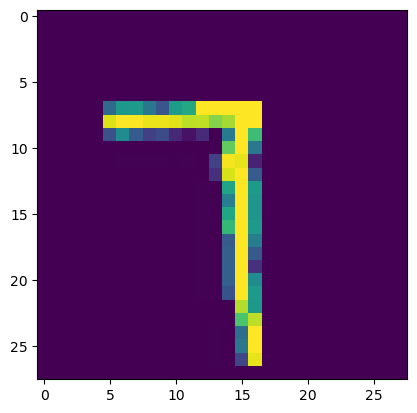

In [11]:
image = (x_test[35][:,:,0])
image = image.reshape([28, 28])
image = np.fliplr(image)
image = np.rot90(image)
plt.imshow(image)

# finally the step of building CNN model to predict numbers

In [12]:
# install model
classifier = Sequential()

# 1- convolution
classifier.add(Conv2D(32,(3,3),input_shape = (28, 28, 1), activation = 'relu'))
classifier.add(BatchNormalization())
# 2- pooling image
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.1))

#3-  Adding a second convolutional layer
classifier.add(Conv2D(64,(3,3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.1)) #used for prevent overfitting model

#3-  Adding a third convolutional layer
classifier.add(Conv2D(32,(3,3),input_shape = (28, 28, 1) ,  activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))
# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection and hidden layers
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
from tensorflow.keras.optimizers import SGD,RMSprop
optimizer = SGD(lr = 0.001 , momentum=0.30)
classifier.compile(optimizer = optimizer , loss = 'categorical_crossentropy'
                   , metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       2

In [13]:
!pip install graphviz
!pip install pydot

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='model.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image("model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]


In [16]:
st_pr_ep = int(len(x_train1) / 256)
vl_step = int(len(x_valid) / 256)
print(st_pr_ep)
print(vl_step)

187
46


In [17]:
history = classifier.fit( x_train1 , 
               y_train1 , 
               epochs = 30 , 
               steps_per_epoch= st_pr_ep , 
               callbacks= callbacks , 
               validation_data=(x_valid , y_valid),
               validation_steps= vl_step )

Epoch 1/30
187/187 [==============================] - 54s 282ms/step - loss: 0.6053 - accuracy: 0.8229 - val_loss: 2.7999 - val_accuracy: 0.2615
Epoch 2/30
187/187 [==============================] - 52s 279ms/step - loss: 0.2152 - accuracy: 0.9446 - val_loss: 1.7456 - val_accuracy: 0.4503
Epoch 3/30
187/187 [==============================] - 52s 281ms/step - loss: 0.1572 - accuracy: 0.9579 - val_loss: 0.1920 - val_accuracy: 0.9497
Epoch 4/30
187/187 [==============================] - 55s 296ms/step - loss: 0.1283 - accuracy: 0.9664 - val_loss: 0.0719 - val_accuracy: 0.9791
Epoch 5/30
187/187 [==============================] - 60s 322ms/step - loss: 0.1119 - accuracy: 0.9698 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 6/30
187/187 [==============================] - 53s 283ms/step - loss: 0.1016 - accuracy: 0.9732 - val_loss: 0.0555 - val_accuracy: 0.9829
Epoch 7/30
187/187 [==============================] - 56s 299ms/step - loss: 0.0928 - accuracy: 0.9753 - val_loss: 0.0492 - val_ac

In [18]:
y_pred = classifier.predict(x_test)
y_pred=np.argmax(y_pred,axis = 1)


313/313 [==============================] - 4s 11ms/step


# Graph that describe the loss and accuracy of the training set and the validation set (Training and validation curves)


In [39]:
# #Draw the loss and accuracy curves of the training set and the validation set.
# # Can judge whether it is under-fitting or over-fitting
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'][0], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'][0], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)


In [40]:

test_lab = pd.read_csv('./test_label.csv')

test_la = test_lab.values

In [41]:
from sklearn.metrics import confusion_matrix , accuracy_score
cm = confusion_matrix(test_la,y_pred)
acc = accuracy_score(test_la , y_pred)

In [42]:
test_la[0:13]

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9],
       [0],
       [1],
       [2],
       [3]], dtype=int64)

In [43]:
y_pred[0:13]

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3], dtype=int64)

In [44]:
print('accuracy :  ' , acc)

accuracy :   0.9881988198819882


In [48]:
score = classifier.evaluate(x_test , y_test )
print('\n' , 'test accourcy : ' , score[1]*100)
print('\n' , 'test1 loss : ' , score[0])

313/313 [==============================] - 3s 11ms/step - loss: 0.0420 - accuracy: 0.9882

 test accourcy :  98.81988167762756

 test1 loss :  0.04201770946383476


In [51]:
classifier.save('Arabic_number_model.h5')